# TME 7 Chaine de Markov Caché

In [1]:
%load_ext autoreload
%autoreload 2
    
import tme7

## Annotation de gènes par chaînes de Markov Caché

Les modeles de chaines de Markov caché sont tres utilisées notament dans les domaines de la reconnaisance de la parole, du traitement automatique du langage naturel, de la reconnaissance de l'écriture manuscrite et de la bioinformatique.

Les 3 problemes de bases des HMM (*Hidden Markov Model*) sont :
1. Évaluation : 
 -  Problème : calculer la probabilité d’observation de la séquence d’observations étant donnée un HMM:  
 -  Solution : *Forward Algorithm *

2. Décodage : 
 - Problème : trouver la séquence d’états qui maximise la séquence d’observations 
 - Solution : *Viterbi Algorithm *

3. Entraînement :  
 - Problème : ajuster les paramètres du modèle HMM afin de maximiser la probabilité de générer une séquence d’observations à partir de données d’entraînement  
  - Solution : *Forward-Backward Algorithm*
  

Dans ce TME, nous allons appliquer l'algorithme Viterbi a des données biologiques.

# Rappel de biologie

Dans ce TME nous allons voir comment les modèles statistiques peuvent être utilisés pour extraire de l'information des données biologiques brutes. Le but sera de spécifier des modèles de Markov cachées qui permettent d'annoter les positions des gènes dans le génome.

Le génome, support de l'information génétique, peut être vu comme une longue séquence de caractères écrite dans un alphabet à 4 lettres: A , C , G et T . Chaque lettre du génome est aussi appelée pair de base (ou bp). Il est maintenant relativement peu coûteux de séquencer un génome (quelques milliers d'euros pour un génome humain). Cependant on ne peut pas comprendre, simplement à partir de la suite de lettres, comment cette information est utilisée par la cellule (un peu comme avoir à disposition un manuel d'instructions écrit dans une langue inconnue).

Un élément essentiel est le gène, qui après transcription et traduction produira les protéines, les molécules responsables de la grande partie de l'activité biochimique des cellules.

La traduction en protéine est faite à l'aide du code génétique qui, à chaque groupe de 3 lettres (ou bp) transcrites fait correspondre un acide aminé. Ces groupes de 3 lettres sont appelés codon et il y en a $4^3$, soit 64. Donc, en première approximation, un gène est défini par les propriétés suivantes (pour les organismes procaryotes):

- Le premier codon, appelé codon start est ATG,
- Il y a 61 codons qui codent pour la séquence d'acides aminés.
- Le dernier codon, appelé codon stop, marque la fin du gène et est l'une des trois séquences TAA , TAG ou TGA . Il n'apparaît pas dans le gène. 


Nous allons intégrer ces différents éléments d'information pour prédire les positions des gènes. Notez que pour simplifier nous avons omis le fait que la molécule d'ADN est constituée de deux brins complémentaires, et donc que les gènes présents sur le brin complémentaire sont vus "à l'envers" sur notre séquence. Les régions entre les gènes sont appelées les régions intergéniques . 

![Image of Yaktocat](https://cdn.kastatic.org/ka-perseus-images/1ade7bbd40ca8dbc7a55ddf4067935e42c347f35.png)

Chacune des séquences de gènes commence par un codon start et fini par un des codons stop. 

# Modélisation de gènes 
## Question 1 : Téléchargement des données

Nous travaillerons sur le premier million de bp du génome de E. coli (souche 042). Plutôt que de travailler avec les lettres A , C , G et T , nous allons les recoder avec des numéros (A =0, …, T =3). Les annontations fournies sont :
- 0 si la position est dans une region non codante = region intergenique
- 1 si la position correspond a la position 0 d'un codon
- 2 si la position correspond a la position 1 d'un codon
- 3 si la position correspond a la position 2 d'un codon

In [2]:
# Telechargez le fichier et ouvrez le avec pickle
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

Genome=np.load('res/genome.npy') # Le premier million de bp de E. coli
Annotation=np.load('res/annotation.npy')# L'annotation sur le genome

## On divise nos donnees, la moitie va nous sevir pour l'apprentissage du modèle
## l'autre partie pour son evaluation

genome_train=Genome[:500000]
genome_test=Genome[500000:]

annotation_train=Annotation[:500000]
annotation_test=Annotation[500000:]


## Question 2 : Apprentissage 

Comme modèle le plus simple pour séparer les séquences de codons des séquences intergéniques, on va définir la **chaîne de Markov caché (CMC)** dont le graphe de transition est donné ci dessous. 

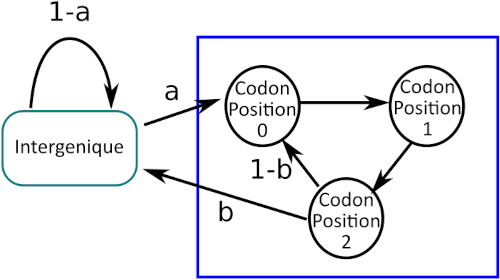

Un tel modèle se défini de la manière suivante : nous considerons qu'il existe 4 états cachés possibles (intergénique, condon 0, codon 1, condon 2).

On peut rester dans les régions intergéniques, et quand on démarre un gène, la composition de chaque base du codon est différente. Il va falloir, afin de pouvoir utiliser ce modèle pour classifier, connaître les paramètres pour la matrice de transition , et les lois $(b_i,i=0,…,3)$ des observations pour les quatre états. 

Etant donné la structure de la CMC (Hidden Markov Chain, HMC en anglais):

- les observations n'influencent pas les états: les matrices $\Pi$ (distribution de probabilité initiale), $A$ (matrice de transition) s'obtiennent comme dans un modèle de Markov simple (cf semaine 6)
- chaque observation ne dépend que de l'état courant 

La nature des données nous pousse à considérer des lois de probabilités discrètes quelconques pour les émissions. L'idée est donc de procéder par comptage en définissant la matrice $B$ (matrice de probabilités des émissions) comme suit:

- $K$ colonnes (nombre d'observations), $N$ lignes (nombre d'états)
- Chaque ligne correspond à une loi d'émission pour un état (ie, chaque ligne somme à 1) 

Ce qui donne l'algorithme:

1. $b_{ij}$ = comptage des émissions depuis l'état $s_i$ vers l'observation $x_j$
2. normalisation des lignes de $B$ 


D'après la définition du modèle, la matrice de transition $A$ a cette forme, il faudra donc estimer les probabilités de tranisition $a$ et $b$ (les autres probas étant nules par construction du modèle) : 
```python
Pi = np.array([1, 0, 0, 0]) # On commence dans l'intergénique
A =  np.array([[1-a, a  , 0, 0], 
               [0  , 0  , 1, 0],
               [0  , 0  , 0, 1],
               [b  , 1-b, 0, 0 ]])
B = ...
```

**Donner le code de la fonction `def learnHMM(allX, allS, N, K):` qui apprend un modèle à partir d'un ensemble de couples (seq. d'observations, seq. d'états).**\
**N.B.: pour effectuer le comptage, discuter la pertinence d'une initialisation avec des 1 au lieu de 0 pour avoir une estimation robuste (cf TME 6)**

In [3]:
nb_etat= 4 ## (0:intergénique, 1:condon 0, 2:codon 1, 3:condon 2)
nb_observation = 4 ## (A,T,C,G)

Pi = np.array([1, 0, 0, 0])

A,B =tme7.learnHMM(genome_train, annotation_train, nb_etat, nb_observation)
print(f"{A=}")
print(f"{B=}")

A=array([[0.99899016, 0.00100984, 0.        , 0.        ],
       [0.        , 0.        , 1.        , 0.        ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.00272284, 0.99727716, 0.        , 0.        ]])
B=array([[0.2434762 , 0.25247178, 0.24800145, 0.25605057],
       [0.24727716, 0.23681872, 0.34909315, 0.16681097],
       [0.28462222, 0.23058695, 0.20782446, 0.27696637],
       [0.1857911 , 0.26246354, 0.29707437, 0.25467098]])


Vous devez trouver (avec une initialisation des matrices A et B avec des 0)

$A= $
```python
[[0.99899016 0.00100984 0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.         1.        ]
 [0.00272284 0.99727716 0.         0.        ]]
```

$B=$       
```python
[[0.2434762  0.25247178 0.24800145 0.25605057]
 [0.24727716 0.23681872 0.34909315 0.16681097]
 [0.28462222 0.23058695 0.20782446 0.27696637]
 [0.1857911  0.26246354 0.29707437 0.25467098]]```

Notez que ce sont des matrices stochastiques : la somme de chaque ligne donne 1.

## Question 3 :  Estimation la séquence d'états par Viterbi

Il n'est pas toujours évident de trouver les régions codante et non codante d'un genome. Nous souhaiterions annonter automatiquement le genome, c'est à dire retrouver **la sequence d'état caché la plus probable** ayant permis de générer la séquence d'observation.

Rappels sur l'algorithme Viterbi (1967):

- Il sert à estimer la séquence d'états la plus probable étant donnés les observations et le modèle.
- Il peut servir à approximer la probabilité de la séquence d'observation étant donné le modèle. 

1\. Initialisation (avec les indices à 0 en python): 

$$\begin{array}{ccccccccc} \delta_{0} (i) &=& \log \pi_{i} +\log b_{i} (x_{1}) \\ \Psi_{0}(i) &=& -1 \mbox{ Note: -1 car non utilisé normalement} \end{array}$$

2\. Récursion: 

$$ \begin{array}{ccccccccc} \delta_{t} (j) &=&\displaystyle \left[\max_{i} \delta_{t-1}(i) + \log a_{ij}\right] + \log b_{j}(x_{t}) \\ \Psi_{t}(j) &=&\displaystyle \arg\max_{i\in [1,\ N]} \delta_{t-1} (i) + \log a_{ij} \end{array}$$

3\. Terminaison (indices à {$T-1$} en python) 

$$ S^{\star} = \max_{i} \delta_{T-1}(i)$$

4\. Chemin $$\begin{array}{ccccccccc} s_{T-1}^{\star} & = &\displaystyle \arg\max_{i} \delta_{T-1}(i) \\ s_{t}^{\star} & = & \displaystyle \Psi_{t+1}(s_{t+1}^{\star}) \end{array}$$

L'estimation de $\log p(x_0^{T-1} | \lambda)$ est obtenue en cherchant la plus grande probabilité dans la dernière colonne de $\delta$. Donner le code de la méthode `viterbi(x,Pi,A,B)` dont voici une ébauche : 

```python
def viterbi(allx,Pi,A,B):
    """
    Parameters
    ----------
    allx : array (T,)
        Sequence d'observations.
    Pi: array, (K,)
        Distribution de probabilite initiale
    A : array (K, K)
        Matrice de transition
    B : array (K, M)
        Matrice d'emission matrix

    """
    
    ## initialisation
    psi = np.zeros((len(A), len(allx))) # A = N
    psi[:,0]= -1
    delta = np.zeros((len(A), len(allx)))  
    
    ## recursion ...  (votre code )
    pass
```


[ -1.41273607 -29.02826658 -28.88761364 -29.31415345]
t= 100000 delta[:,t]= [-136819.91908785 -136814.55299237 -136826.47675612 -136827.60360091]
t= 200000 delta[:,t]= [-274342.92367387 -274340.59622817 -274347.28173628 -274349.19208821]
t= 300000 delta[:,t]= [-412061.48377052 -412068.29439385 -412067.17760811 -412058.27878289]
t= 400000 delta[:,t]= [-549798.22985438 -549792.4983512  -549805.13936952 -549804.77260399]


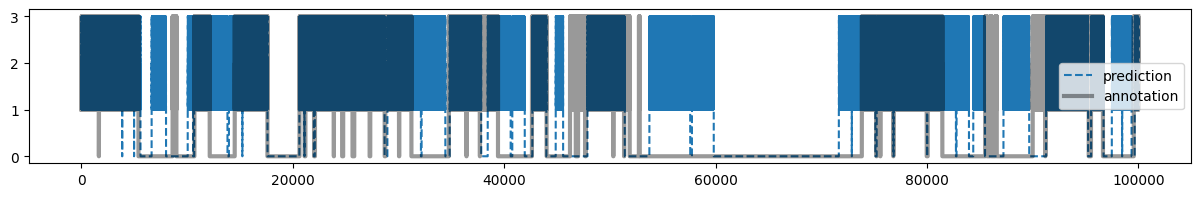

In [4]:
etat_predits=tme7.viterbi(genome_test,Pi,A,B)

fig, ax = plt.subplots(figsize=(15,2))
ax.plot(etat_predits[100000:200000], label="prediction", ls="--")
ax.plot(annotation_test[100000:200000], label="annotation", lw=3, color="black", alpha=.4)
plt.legend(loc="best")
plt.show()

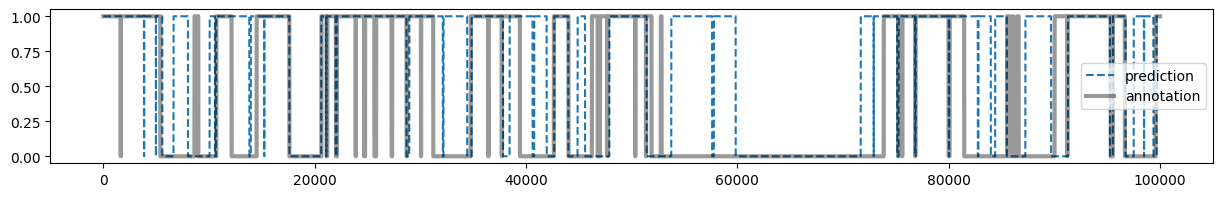

In [5]:
## L'état non codant est l'état 0, les autres (1,2,3) sont les états codants.
##
## Pour plus de visibilié : on ne visualise que les codants ou non
## On distingue dansles états cachés soit en tant que non-codant (0) soit en tant que codant (1)
## dans des tableaux codants_predits et codants_tests
codants_predits,codants_test=tme7.get_and_show_coding(etat_predits,annotation_test)

## Question 4 :  Evaluation des performances

En utilisant codants_predits,codants_test, dessiner la matrice de confusion. 

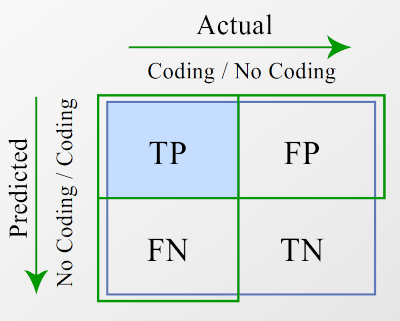

Avec : 
- TP = True Positives, les régions codantes correctement prédictes,
- FP = False Positives, les régions intergénique prédites comme des régions codantes,
- TN = True Negatives, les régions intergeniques prédites correctement,
- FN = False Negatives, les régions codantes prédites comme non codantes.


In [6]:
mat_conf = tme7.create_confusion_matrix(codants_test,codants_predits)

print(f"{mat_conf=}")
print()

TP,FP=mat_conf[0] 
FN,TN=mat_conf[1] 

print(f"  - {TP=}")
print(f"  - {TN=}")
accuracy = (TP+TN)/len(genome_test)*100
print(f"  - {accuracy=:.2f}%")

mat_conf=array([[202819., 152699.],
       [ 31460., 113022.]])

  - TP=np.float64(202819.0)
  - TN=np.float64(113022.0)
  - accuracy=63.17%


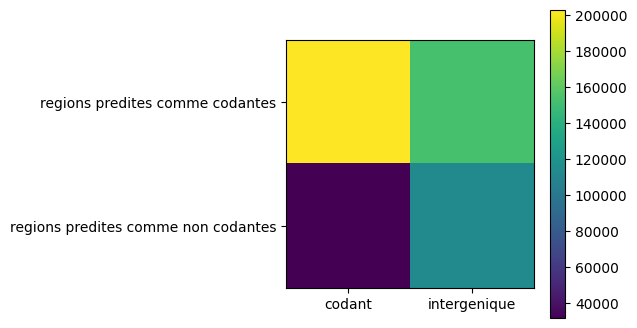

In [7]:
import matplotlib.pyplot as plt 

fig = plt.gcf()
fig.set_size_inches(4,4)
plt.imshow(mat_conf)
plt.colorbar()
ax = plt.gca();

# Major ticks
ax.set_xticks(np.arange(0, 2, 1));
ax.set_yticks(np.arange(0, 2, 1));

# Labels for major ticks
ax.set_xticklabels(['codant','intergenique']);
ax.set_yticklabels(['regions predites comme codantes','regions predites comme non codantes']);

plt.show()


Donner une interprétation.
Peut on utiliser ce model pour prédire la position des gènes dans le génôme ?

## Question 5 :  Optionnel Génération de nouvelles sequences

En utilisant le model $ \lambda=\{Pi,A,B\}$ créer ` create_seq(N,Pi,A,B,states,obs) ` une fonction permétant de générer
- une séquence d'état cachés parmi les états listés dans `states`
- une sequence d'observations parmi les observations listées dans `obs`

In [8]:
tme7.create_seq(20,[0,0,1,0],A,B,states=[0,1,2,3],obs=['A','T','C','G'])


2 A
3 G
1 G
2 A
3 G
1 A
2 A
3 A
1 C
2 A
3 G
1 A
2 G
3 A
1 C
2 A
3 T
1 C
2 G
3 G


([np.int64(2),
  np.int64(3),
  np.int64(1),
  np.int64(2),
  np.int64(3),
  np.int64(1),
  np.int64(2),
  np.int64(3),
  np.int64(1),
  np.int64(2),
  np.int64(3),
  np.int64(1),
  np.int64(2),
  np.int64(3),
  np.int64(1),
  np.int64(2),
  np.int64(3),
  np.int64(1),
  np.int64(2),
  np.int64(3)],
 [np.str_('A'),
  np.str_('G'),
  np.str_('G'),
  np.str_('A'),
  np.str_('G'),
  np.str_('A'),
  np.str_('A'),
  np.str_('A'),
  np.str_('C'),
  np.str_('A'),
  np.str_('G'),
  np.str_('A'),
  np.str_('G'),
  np.str_('A'),
  np.str_('C'),
  np.str_('A'),
  np.str_('T'),
  np.str_('C'),
  np.str_('G'),
  np.str_('G')])

## Question 6 : Construction d'un nouveau modèle

Evaluons maintenant si cela s'améliore en prenant en compte les frontières des gènes en construisant un modèle avec codon start et codon stop.
On veut maintenant d'intégrer l'information complémentaire qui dit qu'un gène commence "toujours" par un codon start et fini "toujours" par un codon stop. 

**On considere donc maintenant un modele avec 10 états cachés:**
- Le premier état (état 0) représente l'intergénique
- Les états 1,2,3 représentent les trois premiers éléments du codon start
- Les états 4,5,6 représentent les trois premiers éléments d'un codon 'interne' de la partie codante de l'ADN (donc tous les codons entre le codon stop et start)
- Les états 7,8,9 représentent les trois premiers éléments du codon stop

Le graphe de transition ci dessous illustre le nouveau modèle : 

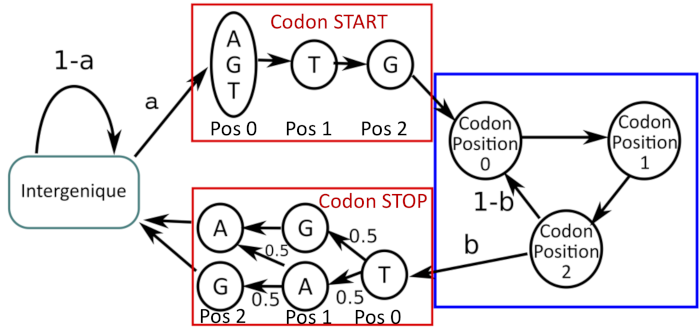

**Pour mettre en place le modèle, il faut changer les annotations sur les états.** Donner le code de la méthode `get_annoatation2(annotation)` qui transforme les annotations avec 4 états en 10 états pour prendre en compte explicitement les codon start et stop :      

In [9]:
annotation_train2 = tme7.get_annoatation2(annotation_train)
print(annotation_train[180:280])
print(annotation_train2[180:280])

[0 0 0 0 0 0 0 0 0 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1
 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2 3 1 2
 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 1 2 3 4 5 6 4 5 6 4 5 6 4 5 6 4 5 6 4 5 6 4 5 6 4 5 6 4
 5 6 4 5 6 4 5 6 4 5 6 4 5 6 4 5 6 4 5 6 4 5 6 4 5 6 4 5 6 4 5 6 4 5 6 7 8
 9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [10]:
Pi2 = np.array([1, 0, 0 , 0 , 0 , 0 , 0 , 0 , 0 , 0  ]) # On commence dans l'intergénique
nb_etat= 10 ## (intergénique, codon START 0, codon START 1, codon START 2, codon INT 0, codon INT 1, codon INT 2, codon STOP 0, codon STOP 1, codon STOP 2)
nb_observation = 4 ## (A,C,G,T)
A2,B2 =tme7.learnHMM(genome_train, annotation_train2, nb_etat, nb_observation)
print(A2)
print(B2)

[[0.99899016 0.00100984 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  1.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.99726225 0.
  0.         0.00273775 0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         1.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         1.        ]
 [1.         0.         0.         0.

Pour le codon start, on sait que les proportions sont les suivantes: ATG : 83% GTG: 14%, et TTG: 3%. Vérfier dans votre modèle appris que cela correspond approximativement sur la base d'apprentissage.

Évaluez les performances du nouveau modèle en faisant de nouvelles prections de genome pour genome_test, et comparez les avec le modèle précédent. 

In [11]:
etat_predits2=tme7.viterbi(genome_test,Pi2,A2,B2)
## On met les etats cache soit a 0 soit a 1, 0 pour non codant et 1 pour codant

[ -1.41273607 -27.81417984 -55.26204223 -32.00887238 -29.03238876
 -28.88837662 -29.32097055 -31.02804313 -28.06405955 -27.82937001]
t= 100000 delta[:,t]= [-136598.24405309 -136603.91142812 -136634.76514071 -136613.42781916
 -136593.68713839 -136606.37901516 -136610.82465057 -136601.58067053
 -136613.19087712 -136615.97939016]
t= 200000 delta[:,t]= [-273934.52863421 -273943.34244522 -273943.49878263 -273947.71493231
 -273930.28554255 -273939.23041665 -273938.86821707 -273934.52686967
 -273948.16395219 -273950.57213729]
t= 300000 delta[:,t]= [-411424.81941358 -411435.1232265  -411433.89263881 -411454.84693439
 -411434.11976439 -411428.44018929 -411423.07189272 -411442.48162036
 -411438.73873445 -411429.02348541]
t= 400000 delta[:,t]= [-548960.06419507 -548967.67599448 -548968.20326471 -548981.30238704
 -548954.70132522 -548968.15221945 -548966.0512325  -548962.38824899
 -548975.84211577 -548974.24320001]


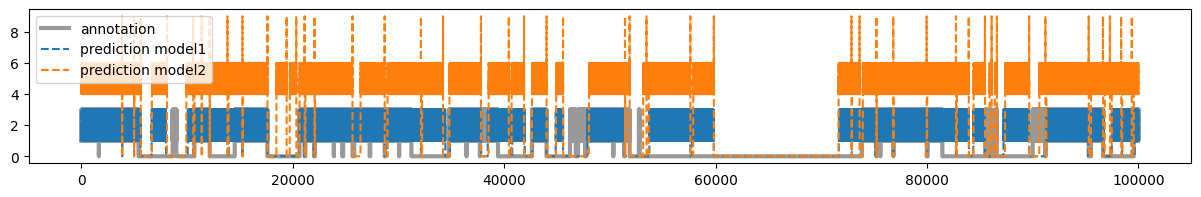

In [12]:
fig, ax = plt.subplots(figsize=(15,2))
ax.plot(annotation_test[100000:200000], label="annotation", lw=3, color="black", alpha=.4)
ax.plot(etat_predits[100000:200000], label="prediction model1", ls="--")
ax.plot(etat_predits2[100000:200000], label="prediction model2", ls="--")

plt.legend(loc="best")
plt.show()

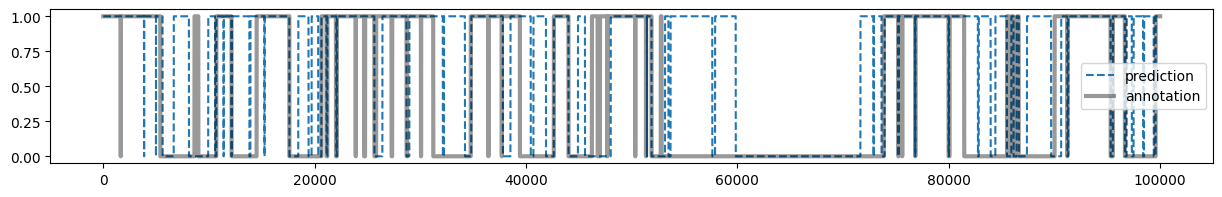

In [13]:
codants_predits2,codants_tests=tme7.get_and_show_coding(etat_predits2,annotation_test)

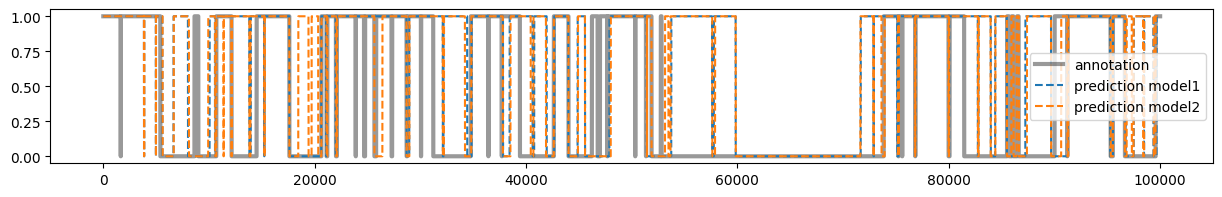

In [14]:
fig, ax = plt.subplots(figsize=(15,2))
ax.plot(codants_tests[100000:200000], label="annotation", lw=3, color="black", alpha=.4)
ax.plot(codants_predits[100000:200000], label="prediction model1", ls="--")
ax.plot(codants_predits2[100000:200000], label="prediction model2", ls="--")

plt.legend(loc="best")
plt.show()

In [15]:
mat_conf2 = tme7.create_confusion_matrix(codants_predits2,codants_test)
print(f"{mat_conf=}")
print()

TP,FP=mat_conf2[0] 
FN,TN=mat_conf2[1] 

print(f"  - {TP=}")
print(f"  - {TN=}")
accuracy = (TP+TN)/len(genome_test)*100
print(f"  - {accuracy=:.2f}%")

mat_conf=array([[202819., 152699.],
       [ 31460., 113022.]])

  - TP=np.float64(211133.0)
  - TN=np.float64(105895.0)
  - accuracy=63.41%
